In [1]:
import numpy as np
import numpy.linalg as lin
import numpy.random as npr  
# import pandas as pd
import scipy.stats as si
import scipy.optimize as sco
from scipy import interpolate 
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

## Parameters

In [2]:
S0 = 100
F0 = 100
G0 = 100

r = 0.04
sigma = 0.2
# t = 0
T = 15
# n = 1
Z = lambda t : np.exp(-r * t) # zero coupon bond

m = 0.01
me = 0.0058

N = 1024
X = 7.5

## Stochastic Mortality Model - Feller Process

In [3]:
ini = 0.00495 # aged 50 years old in 2017
a, sig = 0.08000149236993707, 0.010468669959318862
b = -np.sqrt(a**2 + 2 * sig**2)
c = (b + a) / 2
d = (b - a) / 2
# A = 0
B = lambda t:(1 - np.exp(b * t)) / (c + d * np.exp(b * t))
# S_feller = np.exp(A + B(t)*ini)
S = lambda t:np.exp((1 - np.exp(b * t)) / (c + d * np.exp(b * t)) * ini)
(S(0), S(15))

(1.0, 0.8672053048004046)

## Option by Black–Scholes Formula

In [4]:
def bsmprice(S0, K, r, T, sigma, q):
    if T == 0:
        call = np.maximum(S0 - K, 0)
        put = np.maximum(K - S0, 0)
    else:
        d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        N_d1 = si.norm.cdf(d1, 0.0, 1.0)
        N_d2 = si.norm.cdf(d2, 0.0, 1.0)
        call = S0 * np.exp(-q * T) * N_d1 - K * np.exp(-r * T) * N_d2
        put = K * np.exp(-r * T) * (1 - N_d2) - S0 * np.exp(-q * T) * (1 - N_d1)
    return (call, put)
print(bsmprice(S0, G0, r, T, sigma, m))

def bsmdelta(S0, K, r, T, sigma, q):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    N_d1 = si.norm.cdf(d1, 0.0, 1.0)
    delta_call = np.exp(-q * T) * N_d1
    delta_put = np.exp(-q * T) * (N_d1 - 1)
    return (delta_call, delta_put)
print(bsmdelta(S0, G0, r, T, sigma, m))

def bsmgamma(S0, K, r, T, sigma, q):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    phi_d1 = si.norm.pdf(d1, 0.0, 1.0)
    gamma_call = np.exp(-q * T) / (S0 * sigma * np.sqrt(T)) * phi_d1
    gamma_put = gamma_call
    return (gamma_call, gamma_put)
print(bsmgamma(S0, G0, r, T, sigma, m))

def bsmrho(S0, K, r, T, sigma, q):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    N_d2 = si.norm.cdf(d2, 0.0, 1.0)
    rho_call = K * T * np.exp(-r * T) * N_d2 / 100
    rho_put = -K * T * np.exp(-r * T) * (1 - N_d2) / 100
    return (rho_call, rho_put)
print(bsmrho(S0, G0, r, T, sigma, m))

def bsmvega(S0, K, r, T, sigma, q):
    d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    phi_d1 = si.norm.pdf(d1, 0.0, 1.0)
    vega_call = S0 *np.exp(-q * T) * np.sqrt(T) * phi_d1 / 100
    vega_put = vega_call
    return (vega_call, vega_put)
print(bsmvega(S0, G0, r, T, sigma, m))

(40.089316701019015, 8.899682667915881)
(0.7174338346319131, -0.14327414179314474)
(0.0027740528445923045, 0.0027740528445923045)
(4.748110014325845, -3.484064527084553)
(0.8322158533776913, 0.8322158533776913)


In [5]:
def bsm(S0, K, r, T, sigma, q):
    if T == 0:
        call = np.max(S0 - K, 0)
        put = np.max(K - S0, 0)
    else:
        d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        N_d1 = si.norm.cdf(d1, 0.0, 1.0)
        N_d2 = si.norm.cdf(d2, 0.0, 1.0)
        call = S0 * np.exp(-q * T) * N_d1 - K * np.exp(-r * T) * N_d2
        put = K * np.exp(-r * T) * (1 - N_d2) - S0 * np.exp(-q * T) * (1 - N_d1)

    delta_call = np.exp(-q * T) * N_d1
    delta_put = np.exp(-q * T) * (N_d1 - 1)

    phi_d1 = si.norm.pdf(d1, 0.0, 1.0)
    gamma_call = np.exp(-q * T) / (S0 * sigma * np.sqrt(T)) * phi_d1
    gamma_put = gamma_call
   
    rho_call = K * T * np.exp(-r * T) * N_d2 / 100
    rho_put = -K * T * np.exp(-r * T) * (1 - N_d2) / 100

    vega_call = S0 *np.exp(-q * T) * np.sqrt(T) * phi_d1 / 100
    vega_put = vega_call
    return (call, delta_call, gamma_call, rho_call, vega_call, put, delta_put, gamma_put, rho_put, vega_put)
print(bsm(S0, G0, r, T, sigma, m))

(40.089316701019015, 0.7174338346319131, 0.0027740528445923045, 4.748110014325845, 0.8322158533776913, 8.899682667915881, -0.14327414179314474, 0.0027740528445923045, -3.484064527084553, 0.8322158533776913)


## GMMB Price

## GMMB Loss by FST Method

In [8]:
def bsmloss_gmmb_fst(S0, G, T, r, sigma, m, me, N, X):
    # real space
    x_min = -X
    x_max = X
    dx = (x_max - x_min) / (N-1)
    x = np.linspace(x_min, x_max, N)
    # fourier space
    epsilon = 0.0001
    w_max = np.pi / dx # 1/(2*dx)
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # characteristic exponent - BSM
    psi = 1j * (r - m - 0.5 * sigma ** 2) * w - 0.5 * (sigma * w) ** 2 - r
    ST = S0 * np.exp(x)
    # calculate put opiton
    payoff_p = np.maximum(G - ST, 0)
    char = np.exp(psi * T) # char_exp_factor
    p = ifft(fft(payoff_p) * char).real
    f = interpolate.PchipInterpolator(ST, p)
    P = f(S0) + 0.0
    # calculate rider charges
    Re = []
    for i in range(T):
        payoff_r = me * ST * S(i)
        char_i = np.exp(psi * i)
        re = ifft(fft(payoff_r) * char_i).real
        f = interpolate.PchipInterpolator(ST, re)
        Re.append(f(S0) + 0.0)
    Re = np.sum(Re)
    # calculate GMMB loss
    Loss = S(T) * P - Re
    return (Loss, P)

bsmloss_gmmb_fst(S0, G0, T, r, sigma, m, me, N, X)

(-0.0018843721656596202, 8.89993122723573)

## Analytical Solution

In [9]:
Re = []
for i in range(T):
    temp = np.exp(-r * i) * me * S0 * np.exp((r - m) * i) * S(i)
    Re.append(temp)
Put = bsmprice(S0, G0, r, T, sigma, m)[1]
S(T) * Put - np.sum(Re)

-0.0020999239460852692

## Fair Rates (m, me)

array(0.00579858)

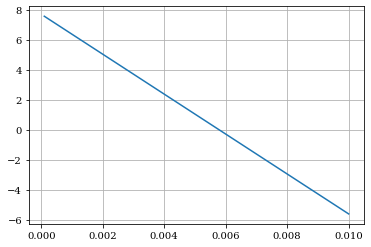

In [10]:
me = np.linspace(0.0001, 0.01)
loss = []
for i in me:
    temp = bsmloss_gmmb_fst(S0, G0, T, r, sigma, m, i, N, X)[0]
    loss.append(temp)
plt.plot(me, loss)
plt.grid()
f = interpolate.PchipInterpolator(loss[::-1], me[::-1])
me = f(0) # fair rate of me
me

In [11]:
bsmloss_gmmb_fst(S0, G0, T, r, sigma, m, me, N, X)[0]

5.1514348342607263e-14

## GMMB Greeks by FST Method

In [12]:
me

array(0.00579858)

In [13]:
def bsmgreeks_gmmb_fst(S0, G, T, r, sigma, m, me, N, X):
    # real space
    x_min = -X
    x_max = X
    dx = (x_max - x_min) / (N-1)
    x = np.linspace(x_min, x_max, N)
    # fourier space
    epsilon = 0.0001
    w_max = np.pi / dx # 1/(2*dx)
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # FT
    ST = S0 * np.exp(x)
    # characteristic exponent - BSM
    psi = 1j*(r-m-0.5*sigma**2)*w - 0.5*(sigma*w)**2 - r
    char = np.exp(psi * T) # char_exp_factor
    # payoff function of put option
    payoff_p = np.maximum(G - ST, 0)
    # put option's value, delta, gamma, rho, vega
    p = ifft(fft(payoff_p) * char).real
    de_p = (ifft(1j*w*fft(payoff_p)*char)/(ST)).real
    ga_p = (ifft(-(1j*w+w**2)*fft(payoff_p)*char)/(ST**2)).real
    rh_p = ifft((1j*w-1)*T*fft(payoff_p)*char).real / 100
    ve_p = ifft(-(1j*w+w**2)*sigma*T*fft(payoff_p)*char).real / 100
    # interpolate
    f = interpolate.PchipInterpolator(ST, p)
    P = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, de_p)
    De_P = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, ga_p)
    Ga_P = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, rh_p)
    Rh_P = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, ve_p)
    Ve_P = f(S0) + 0.0
    # rider charges
    Re = []
    De_Re = []
    Ga_Re = []
    Rh_Re = []
    Ve_Re = []
    Mu_Re = []
    Musq_Re = []
    # t = 0, 1, 2, ..., 14
    for i in range(T):
        # payoff function of rider charges
        payoff_re = me * ST * S(i)
        # rider charges' value, delta, gamma, rho, vega, beta, betasq
        char_i = np.exp(psi*i)
        re = ifft(fft(payoff_re) * char_i).real
        de_re = (ifft(1j*w*fft(payoff_re)*char_i)/(ST)).real
        ga_re = (ifft(-(1j*w+w**2)*fft(payoff_re)*char_i)/(ST**2)).real  
        rh_re = ifft((1j*w-1)*i*fft(payoff_re)*char_i).real / 100
        ve_re = ifft(-(1j*w+w**2)*sigma*i*fft(payoff_re)*char_i).real / 100
        mu_re = ifft(fft(B(i)*payoff_re)*char_i).real
        musq_re = ifft(fft(B(i)**2*payoff_re)*char_i).real
        # interpolate
        f = interpolate.PchipInterpolator(ST, re)
        Re.append(f(S0) + 0.0)
        f = interpolate.PchipInterpolator(ST, de_re)
        De_Re.append(f(S0) + 0.0)
        f = interpolate.PchipInterpolator(ST, ga_re)
        Ga_Re.append(f(S0) + 0.0)
        f = interpolate.PchipInterpolator(ST, rh_re)
        Rh_Re.append(f(S0) + 0.0)
        f = interpolate.PchipInterpolator(ST, ve_re)
        Ve_Re.append(f(S0) + 0.0)
        f = interpolate.PchipInterpolator(ST, mu_re)
        Mu_Re.append(f(S0) + 0.0)
        f = interpolate.PchipInterpolator(ST, musq_re)
        Musq_Re.append(f(S0) + 0.0)
    # GMMB's delta, gamma, rho, vega, mu, musq
    L = S(T) * P - np.sum(Re)
    De_L = S(T) * De_P - np.sum(De_Re)
    Ga_L = S(T) * Ga_P - np.sum(Ga_Re)
    Rh_L = S(T) * Rh_P - np.sum(Rh_Re)
    Ve_L = S(T) * Ve_P - np.sum(Ve_Re)
    # S_feller = np.exp(A + B(t)*ini)
    Mu_L = B(T) * S(T) * P - np.sum(Mu_Re)
    Musq_L = B(T)**2 * S(T) * P - np.sum(Musq_Re)
    return (P, De_P, Ga_P, Rh_P, Ve_P, L, De_L, Ga_L, Rh_L, Ve_L, Mu_L, Musq_L)

bsmgreeks_gmmb_fst(S0, G0, T, r, sigma, m, me, N, X)

(8.89993122723573,
 -0.14327476477142465,
 0.0027740192482038875,
 -3.4841111342638316,
 0.832205868232,
 5.1514348342607263e-14,
 -0.20312409683806842,
 0.0025158138008682194,
 -3.021439658174497,
 0.721693343610857,
 -144.65403429476075,
 5151.279820459928)

## Plots

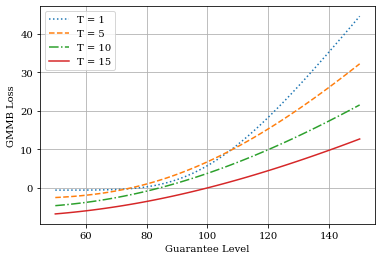

In [15]:
guarantee = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
# plt.figure(figsize=(10,6))
for j in range(len(time)):
    v = []
    for i in guarantee:
        temp = bsmgreeks_gmmb_fst(S0, i, time[j], r, sigma, m, me, N, X)[5]
        v.append(temp)
    plt.plot(guarantee, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Guarantee Level')
plt.ylabel('GMMB Loss')
plt.grid()

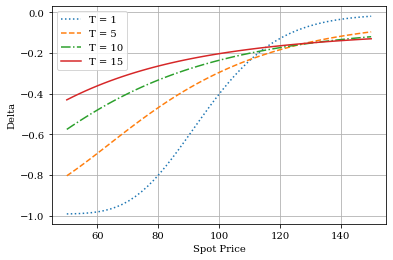

In [16]:
# return (P, De_P, Ga_P, Rh_P, Ve_P, L, De_L, Ga_L, Rh_L, Ve_L, Mu_L, Musq_L)
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = bsmgreeks_gmmb_fst(i, G0, time[j], r, sigma, m, me, N, X)[6]
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.ylabel('Delta')
plt.grid()

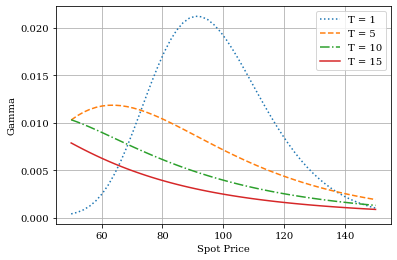

In [17]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = bsmgreeks_gmmb_fst(i, G0, time[j], r, sigma, m, me, N, X)[7]
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.ylabel('Gamma')
plt.grid()

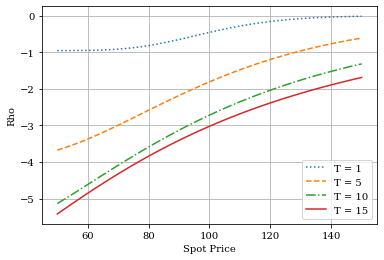

In [18]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = bsmgreeks_gmmb_fst(i, G0, time[j], r, sigma, m, me, N, X)[8]
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.ylabel('Rho')
plt.grid()

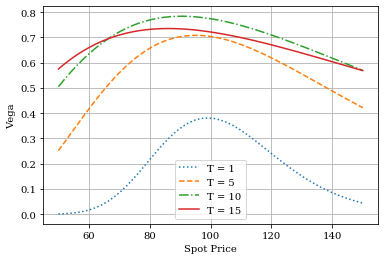

In [19]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = bsmgreeks_gmmb_fst(i, G0, time[j], r, sigma, m, me, N, X)[9]
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.ylabel('Vega')
plt.grid()

## Hedging Stratedgy

## Weights 8

In [110]:
# # (P, De_P, Ga_P, Rh_P, Ve_P, L, De_L, Ga_L, Rh_L, Ve_L, Mu_L, Musq_L)
# # 0:GMMB(15), 1:P(16), 2:P(17), 3:P(18), 4:f(16), 5:f(17), 6:Z(16), 7:Z(17)
# # GMMB(15) = Put(16) + Put(17) + Put(18) + f(16) + f(17) +Z(16) + Z(18) 
# Port8 = np.zeros((7, 8))

# Port8[:, 0] = bsmgreeks_gmmb_fst(S0, G0, T, r, sigma, m, me, N, X)[5:] # GMMB(15)

# for i in range(16, 19):
#     Port8[:5, i-15] = bsm(S0, G0, r, i, sigma, 0)[5:] # Put

# for i in range(16, 18):
#     # Z(t) = np.exp(-r * t)
#     # S(t) = np.exp(B(t)*ini)
#     # Zero-coupon bond
#     Port8[0, i-10] = Z(i) # Price
#     Port8[3, i-10] = -i * Z(i)# Rho
#     # F-forward
#     Port8[0, i-12] = S(i) * Z(i) # Price
#     Port8[3, i-12] = -i * S(i) * Z(i)# Rho
#     Port8[5, i-12] = B(i) * S(i) * Z(i) # Mu
#     Port8[6, i-12] = B(i) ** 2 * S(i) * Z(i)# Musq

# print(Port8)
# Weights8 = np.zeros((8))
# Weights8[0] = -1
# Weights8[1:] = lin.solve(Port8[:, 1:], Port8[:, 0])
# Weights8

[[ 5.15143483e-14  6.66238349e+00  6.42218769e+00  6.18503259e+00
   4.49671457e-01  4.24294113e-01  5.27292424e-01  5.06616992e-01]
 [-2.03124097e-01 -1.15069670e-01 -1.08056222e-01 -1.01545894e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.51581380e-03  2.42732569e-03  2.25123240e-03  2.09153573e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.02143966e+00 -2.90709608e+00 -2.92872769e+00 -2.94113195e+00
  -7.19474331e+00 -7.21299992e+00 -8.43667878e+00 -8.61248887e+00]
 [ 7.21693344e-01  7.76744220e-01  7.65419016e-01  7.52952861e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.44654034e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.44656181e+01 -1.51998782e+01  0.00000000e+00  0.00000000e+00]
 [ 5.15127982e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.65348878e+02  5.44519212e+02  0.00000000e+00  0.00000000e+00]]


array([-1.00000000e+00, -8.73872474e+02,  1.88854167e+03, -1.01736597e+03,
        5.82501250e-01,  8.96242669e+00, -4.62386004e+02,  4.45492738e+02])

In [111]:
# Port8[0].dot(Weights8)

-9.094947017729282e-13

## Monte Carlo Simulation

In [14]:
I = 2000    
M = 15
dt = T / M
MC = np.zeros((M + 1, I))  
MC[0] = S0  
BM = npr.standard_normal((M, I))
for t in range(1, T + 1):
    MC[t] = MC[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
            sigma * np.sqrt(dt) * BM[t - 1])  

## Unhedged

In [26]:
# bsmloss_gmmb_fst(S0, G0, T, r, sigma, m, me, N, X)
for j in range(M + 1): # j = 0,1,2,...,15
    Unhedged = []
    for i in MC[j]:
        temp = bsmloss_gmmb_fst(i, G0, 15-j, r, sigma, m, me, N, X)[0]
        Unhedged.append(temp)
    print(j, np.mean(Unhedged), np.std(Unhedged))

0 5.1514348342607263e-14 0.0
1 0.40924768615203744 4.302979109862059
2 0.8170820303733776 6.1644126050242685
3 1.1913536696894975 7.499744953466147
4 1.7511608827071687 8.868485204592782
5 2.7012809668282496 10.174443678171963
6 3.3619139147082984 11.129408380029657
7 4.145063896725008 12.398075821977955
8 5.204060346515696 13.6570624905356
9 6.188482349255952 14.966773181975098
10 7.095390873698343 15.819211338397114
11 8.000834030135579 16.57914679023255
12 9.1160139271422 17.6622281443985
13 10.340367284718788 18.75361447746914
14 11.588366510067186 19.902241992946188
15 12.816683221131273 21.42846506512681


In [17]:
# plt.hist(Unhedged, bins=50)

## Portfolio 8

In [43]:
# def portfolio8(S0, G0, T, r, sigma, m, me, N, X):
#     Sys8 = np.zeros((7, 8))
#     Sys8[:, 0] = bsmgreeks_gmmb_fst(S0, G0, T, r, sigma, m, me, N, X)[5:] # GMMB(15)

#     for i in range(16, 19):
#         Sys8[:5, i-15] = bsm(S0, G0, r, i, sigma, 0)[5:] # Put

#     for i in range(16, 18):
#         # Z(t) = np.exp(-r * t)
#         # S(t) = np.exp(B(t)*ini)
#         # Zero-coupon bond
#         Sys8[0, i-10] = Z(i) # Price
#         Sys8[3, i-10] = -i * Z(i)# Rho
#         # F-forward
#         Sys8[0, i-12] = S(i) * Z(i) # Price
#         Sys8[3, i-12] = -i * S(i) * Z(i)# Rho
#         Sys8[5, i-12] = B(i) * S(i) * Z(i) # Mu
#         Sys8[6, i-12] = B(i) ** 2 * S(i) * Z(i)# Musq

#     Weights8 = np.zeros((8))
#     Weights8[0] = -1
#     Weights8[1:] = lin.solve(Sys8[:, 1:], Sys8[:, 0])
#     return (Sys8, Weights8)

# System8 = portfolio8(S0, G0, T, r, sigma, m, me, N, X)[0]
# Weights8 = portfolio8(S0, G0, T, r, sigma, m, me, N, X)[1]
# System8.dot(Weights8)

In [ ]:
# for j in range(M + 1): # j = 0,1,2,...,15
# # for j in range(3):
#     Static8 = []
#     temp = np.zeros(8)
#     for i in MC[j]:
#         temp[0] = bsmloss_gmmb_fst(i, G0, 15-j, r, sigma, m, me, N, X)[0]
#         temp[1] = bsmprice(i, G0, r, 16-j, sigma, 0)[1]
#         temp[2] = bsmprice(i, G0, r, 17-j, sigma, 0)[1]
#         temp[3] = bsmprice(i, G0, r, 18-j, sigma, 0)[1]
#         temp[4] = S(16) * Z(16-j)
#         temp[5] = S(17) * Z(17-j)
#         temp[6] = Z(16-j)
#         temp[7] = Z(17-j)
#         Static8.append(temp.dot(Weights8))
#     print(j, np.mean(Static8), np.std(Static8))

## Static 6

In [31]:
## Equation System 1 - Present Values and Weights
def portfolio6(S0, G0, t, r, sigma, m, me, N, X):
    Sys6 = np.zeros((5, 6))
    Sys6[0:3, 0] = bsmgreeks_gmmb_fst(S0, G0, t, r, sigma, m, me, N, X)[5:8] # GMMB(15)
    Sys6[3, 0] = bsmgreeks_gmmb_fst(S0, G0, t, r, sigma, m, me, N, X)[10] # GMMB(15)
    Sys6[4, 0] = bsmgreeks_gmmb_fst(S0, G0, t, r, sigma, m, me, N, X)[11] # GMMB(15)

    Sys6[:3, 1] = bsm(S0, G0, r, t+1, sigma, 0)[5:8]
    Sys6[:3, 2] = bsm(S0, G0, r, t+2, sigma, 0)[5:8]

    Sys6[0, 3] = S(16) * Z(t+1) # Price
    Sys6[3, 3] = B(16) * S(16) * Z(t+1) # Mu
    Sys6[4, 3] = B(16) ** 2 * S(16) * Z(t+1)# Musq

    Sys6[0, 4] = S(17) * Z(t+2) # Price
    Sys6[3, 4] = B(17) * S(17) * Z(t+2) # Mu
    Sys6[4, 4] = B(17) ** 2 * S(17) * Z(t+2)# Musq

    Sys6[0, 5] = Z(t+1) # Z(16)

    Weights6 = np.zeros((6))
    Weights6[0] = -1
    Weights6[1:] = lin.solve(Sys6[:, 1:], Sys6[:, 0])
    return (Sys6[0], Weights6)

Portfolio6 = portfolio6(S0, G0, T, r, sigma, m, me, N, X)
# Pv6 = Portfolio6[0]
# Pv6.dot(Weights6)
print(Portfolio6)
SW6 = Portfolio6[1] # Static Weights

(array([5.15143483e-14, 6.66238349e+00, 6.42218769e+00, 4.49671457e-01,
       4.24294113e-01, 5.27292424e-01]), array([ -1.        , -57.24790493,  62.84341141,   0.58250125,
         8.96242669, -49.78134352]))


In [32]:
# Present Value
def pv6(S0, t):
    PV6 = np.zeros(6)
    PV6[0] = bsmloss_gmmb_fst(S0, G0, t, r, sigma, m, me, N, X)[0]
    PV6[1] = bsmprice(S0, G0, r, t+1, sigma, 0)[1]
    PV6[2] = bsmprice(S0, G0, r, t+2, sigma, 0)[1]
    PV6[3] = S(16) * Z(t+1)
    PV6[4] = S(17) * Z(t+2)
    PV6[5] = Z(t+1)
    return PV6
pv6(100, 15)

array([5.15143483e-14, 6.66238349e+00, 6.42218769e+00, 4.49671457e-01,
       4.24294113e-01, 5.27292424e-01])

In [39]:
for j in range(T + 1): # j = 0,1,2,...,15
# for j in range(2):
    Static6 = []
    #temp = np.zeros(6)
    for i in MC[j]:
        PV6 = pv6(i, T-j)
        Static6.append(PV6.dot(SW6))
    print(j, np.mean(Static6), np.std(Static6))

0 0.0 0.0
1 -0.4604149817900361 0.13356182634941538
2 -0.9545328116485707 0.3695038024899202
3 -1.48220042853289 0.7388939444445483
4 -2.067268618348025 1.2034221639188718
5 -2.719584048506972 1.889831198217512
6 -3.4239549936536973 2.862255809601041
7 -4.160749370968621 4.054483106448524
8 -4.903122402824392 5.5847285048838655
9 -5.82425844251326 7.414676629326991
10 -6.832486618323697 9.629575264402007
11 -7.741420800565217 12.888181308110296
12 -9.40963872322588 16.88107663188436
13 -10.551310924352322 22.835887142661218
14 -11.671857056507761 31.093194753070243
15 -12.72224599790349 46.09581260198151


## Semi - Static 6

In [64]:
# SW6_4
SW6_4 = np.zeros((I, 6))
j = 4
price = MC[j]
for i in range(len(price)):
    Sys6[0:3, 0] = bsmgreeks_gmmb_fst(price[i], G0, T-j, r, sigma, m, me, N, X)[5:8] # GMMB(15)
    Sys6[3, 0] = bsmgreeks_gmmb_fst(price[i], G0, T-j, r, sigma, m, me, N, X)[10] # GMMB(15)
    Sys6[4, 0] = bsmgreeks_gmmb_fst(price[i], G0, T-j, r, sigma, m, me, N, X)[11] # GMMB(15)

    Sys6[:3, 1] = bsm(price[i], G0, r, T-j+1, sigma, 0)[5:8]
    Sys6[:3, 2] = bsm(price[i], G0, r, T-j+2, sigma, 0)[5:8]

    Sys6[0, 3] = S(16) * Z(T-j+1) # Price
    Sys6[3, 3] = B(16) * S(16) * Z(T-j+1) # Mu
    Sys6[4, 3] = B(16) ** 2 * S(16) * Z(T-j+1)# Musq

    Sys6[0, 4] = S(17) * Z(T-j+2) # Price
    Sys6[3, 4] = B(17) * S(17) * Z(T-j+2) # Mu
    Sys6[4, 4] = B(17) ** 2 * S(17) * Z(T-j+2)# Musq

    Sys6[0, 5] = Z(T-j+1) # Z(16)

    Weights6[0] = -1
    Weights6[1:] = lin.solve(Sys6[:, 1:], Sys6[:, 0])
    SW6_4[i] = Weights6

In [65]:
# SW6_8
SW6_8 = np.zeros((I, 6))
j = 8
price = MC[j]
for i in range(len(price)):
    Sys6[0:3, 0] = bsmgreeks_gmmb_fst(price[i], G0, T-j, r, sigma, m, me, N, X)[5:8] # GMMB(15)
    Sys6[3, 0] = bsmgreeks_gmmb_fst(price[i], G0, T-j, r, sigma, m, me, N, X)[10] # GMMB(15)
    Sys6[4, 0] = bsmgreeks_gmmb_fst(price[i], G0, T-j, r, sigma, m, me, N, X)[11] # GMMB(15)

    Sys6[:3, 1] = bsm(price[i], G0, r, T-j+1, sigma, 0)[5:8]
    Sys6[:3, 2] = bsm(price[i], G0, r, T-j+2, sigma, 0)[5:8]

    Sys6[0, 3] = S(16) * Z(T-j+1) # Price
    Sys6[3, 3] = B(16) * S(16) * Z(T-j+1) # Mu
    Sys6[4, 3] = B(16) ** 2 * S(16) * Z(T-j+1)# Musq

    Sys6[0, 4] = S(17) * Z(T-j+2) # Price
    Sys6[3, 4] = B(17) * S(17) * Z(T-j+2) # Mu
    Sys6[4, 4] = B(17) ** 2 * S(17) * Z(T-j+2)# Musq

    Sys6[0, 5] = Z(T-j+1) # Z(16)

    Weights6[0] = -1
    Weights6[1:] = lin.solve(Sys6[:, 1:], Sys6[:, 0])
    SW6_8[i] = Weights6

In [66]:
# SW6_12
SW6_12 = np.zeros((I, 6))
j = 12
price = MC[j]
for i in range(len(price)):
    Sys6[0:3, 0] = bsmgreeks_gmmb_fst(price[i], G0, T-j, r, sigma, m, me, N, X)[5:8] # GMMB(15)
    Sys6[3, 0] = bsmgreeks_gmmb_fst(price[i], G0, T-j, r, sigma, m, me, N, X)[10] # GMMB(15)
    Sys6[4, 0] = bsmgreeks_gmmb_fst(price[i], G0, T-j, r, sigma, m, me, N, X)[11] # GMMB(15)

    Sys6[:3, 1] = bsm(price[i], G0, r, T-j+1, sigma, 0)[5:8]
    Sys6[:3, 2] = bsm(price[i], G0, r, T-j+2, sigma, 0)[5:8]

    Sys6[0, 3] = S(16) * Z(T-j+1) # Price
    Sys6[3, 3] = B(16) * S(16) * Z(T-j+1) # Mu
    Sys6[4, 3] = B(16) ** 2 * S(16) * Z(T-j+1)# Musq

    Sys6[0, 4] = S(17) * Z(T-j+2) # Price
    Sys6[3, 4] = B(17) * S(17) * Z(T-j+2) # Mu
    Sys6[4, 4] = B(17) ** 2 * S(17) * Z(T-j+2)# Musq

    Sys6[0, 5] = Z(T-j+1) # Z(16)

    Weights6[0] = -1
    Weights6[1:] = lin.solve(Sys6[:, 1:], Sys6[:, 0])
    SW6_12[i] = Weights6

In [67]:
# for j in range(1, T + 1): # j = 0,1,2,...,15
for j in range(T + 1):
    Static6 = []
    Sys6 = np.zeros((5, 6))
    Weights6 = np.zeros((6))

    if j < 4:
        for i in MC[j]:
            PV6 = pv6(i, T-j)
            Static6.append(PV6.dot(SW6))

    if 4 <= j < 8:
        price = MC[j]
        for i in range(len(price)):
            PV6 = pv6(price[i], T-j)
            Static6.append(PV6.dot(SW6_4[i]))

    if 8 <= j < 12:
        price = MC[j]
        for i in range(len(price)):
            PV6 = pv6(price[i], T-j)
            Static6.append(PV6.dot(SW6_8[i]))

    if 12 <= j:
        price = MC[j]
        for i in range(len(price)):
            PV6 = pv6(price[i], T-j)
            Static6.append(PV6.dot(SW6_12[i]))

    print(j, np.mean(Static6), np.std(Static6))

0 0.0 0.0
1 -0.4604149817900361 0.13356182634941538
2 -0.9545328116485707 0.3695038024899202
3 -1.48220042853289 0.7388939444445483
4 -1.254818471352337e-14 4.304081313885191e-13
5 -0.5417831381199837 0.9870638865978547
6 -1.208126641051661 4.862911542731018
7 -2.1721892715177855 13.23075483131303
8 nan nan
9 -0.7117453593911556 1.9590182846834436
10 -1.3386892507405392 4.435014114615287
11 -1.6268011162086773 12.729086766653083
12 2.7482460751571126e-15 6.675228537930767e-14
13 -0.838032753797163 1.8464645098481003
14 -1.6945928748166479 4.271345752134263
15 -2.38643169781362 13.36411594918612


In [ ]:
0 0.0 0.0
1 -0.4604149817900361 0.13356182634941538
2 -0.9545328116485707 0.3695038024899202
3 -1.48220042853289 0.7388939444445483
4 -2.067268618348025 1.2034221639188718
5 -2.719584048506972 1.889831198217512
6 -3.4239549936536973 2.862255809601041
7 -4.160749370968621 4.054483106448524
8 -4.903122402824392 5.5847285048838655
9 -5.82425844251326 7.414676629326991
10 -6.832486618323697 9.629575264402007
11 -7.741420800565217 12.888181308110296
12 -9.40963872322588 16.88107663188436
13 -10.551310924352322 22.835887142661218
14 -11.671857056507761 31.093194753070243
15 -12.72224599790349 46.09581260198151